---
title: "UMAP on low rank matrix and loadings"
author: "Saikat Banerjee"
format:
  html: default
date: "2024-04-03"
file-modified: "2024-04-03"
abstract: "To understand the disease network, we plot an interactive UMAP from the loadings of the latent factors."

---

# Setup

We have to first load a bunch of useful tools including [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) 
and [Bokeh](https://docs.bokeh.org/en/latest/index.html). 

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import re

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

import umap
from bokeh.plotting import figure as bokeh_figure
from bokeh.plotting import show as bokeh_show
from bokeh.layouts import column as bokeh_column
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import CategoricalColorMapper

output_notebook()

Loading BokehJS ...

# Load data and results

Here, we explore the low rank model from nuclear norm minimization with the sparse matrix.

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/results/nnsparsh"

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_all.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_all_with_desc.pkl"))
zscore_df_noRx = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_noRx.pkl"))

method = 'nnm_sparse'

res_filename = os.path.join(result_dir, "full", f"{method}_model.pkl")
with (open(res_filename, "rb")) as fh:
    lowrank_model = pickle.load(fh)
    
res_filename_noRx = os.path.join(result_dir, "noRx", f"{method}_model.pkl")
with (open(res_filename_noRx, "rb")) as fh:
    lowrank_model_noRx = pickle.load(fh)

X = np.array(zscore_df.drop(labels = ['rsid'], axis = 1).values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)

X_noRx = np.array(zscore_df_noRx.values.T)
X_noRx_cent = X_noRx - np.mean(X_noRx, axis = 0, keepdims = True)

lowX = lowrank_model['X_']
lowX_cent = lowX - np.mean(lowX, axis = 0, keepdims = True)
lowX_std = lowX_cent / np.sqrt(np.prod(lowX_cent.shape))

lowX_noRx = lowrank_model_noRx['X_']
lowX_noRx_cent = lowX_noRx - np.mean(lowX_noRx, axis = 0, keepdims = True)
lowX_noRx_std = lowX_noRx_cent / np.sqrt(np.prod(lowX_noRx_cent.shape))

print ("Nuclear Norms")
print (f"Low rank model: {np.linalg.norm(lowX, ord = 'nuc'):.3f}")
print (f"Low rank model without Rx: {np.linalg.norm(lowX_noRx, ord = 'nuc'):.3f}")
print (f"Input data: {np.linalg.norm(X, ord = 'nuc'):.3f}")
print (f"Input data (mean centered): {np.linalg.norm(X_cent, ord = 'nuc'):.3f}")

Nuclear Norms
Low rank model: 8050.750
Low rank model without Rx: 8059.143
Input data: 496751.155
Input data (mean centered): 495872.387


# Compute loadings

We compute the loadings from the SVD of the low rank approximation of the input data. We use the top 100 factors and their loadings.

To-Do: Save the loadings and factors so that we don't have to calculate it every time.

In [109]:
def compute_loadings_factors(X, k = None):
    #X_cent = mpy_simulate.do_standardize(X, scale = False)
    #X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X, full_matrices = False)
    S2 = np.square(S)
    explained_variance = S2 / np.sum(S2)
    if k is None:
        k = np.where(explained_variance < 1e-12)[0][0] - 1
    U_low = U[:, :k]
    S_low = S[:k]
    factors = Vt[:k, :].T
    loadings = U_low @ np.diag(S_low)
    return U_low, S_low, loadings, factors

U0, S0, loadings0, factors0 = compute_loadings_factors(lowX_std)
U1, S1, loadings1, factors1 = compute_loadings_factors(lowX_noRx_std)
U2, S2, loadings2, factors2 = compute_loadings_factors(X_cent)
U3, S3, loadings3, factors3 = compute_loadings_factors(X_noRx_cent)

nnm_loadings  = loadings0.copy()
nnm_loadings_noRx = loadings1.copy()
tsvd_loadings = U2[:, :loadings0.shape[1]] @ np.diag(S2[:loadings0.shape[1]])
tsvd_loadings_noRx = U3[:, :loadings1.shape[1]] @ np.diag(S3[:loadings1.shape[1]])

In [111]:
def make_single_plot_principal_components(ax, i, j, comps, labels, label_color_dict, alphas):
    pc1 = comps[:, j]
    pc2 = comps[:, i]
    for label, color in label_color_dict.items():
        idx = np.where(labels == label)[0]
        if idx.shape[0] > 0:
            ax.scatter(pc1[idx], pc2[idx], s = 50, alpha = alphas[idx], label = label, color = color)
    return

def make_plot_principal_components_diag(pcomp, class_labels, class_colors,
        h2 = None, alpha_factor = 10,
        ncomp = 6,
        subplot_h = 2.0, bgcolor = "#F0F0F0"):

    '''
    pcomp: principal components
    class_labels: the class of each sample
    class_colors: dict of class colors for each label
    '''

    nrow = ncomp - 1
    ncol = ncomp - 1
    figw = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
    figh = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5

    fig = plt.figure(figsize = (figw, figh))
    axmain = fig.add_subplot(111)
    axs = list()
    
    if h2 is None:
        alpha_arr = np.full([pcomp.shape[0],], 0.6)
    else:
        alpha_arr = np.array([min(0.6, alpha_factor * abs(x)) for x in h2])

    for i in range(1, nrow + 1):
        for j in range(ncol):
            ax = fig.add_subplot(nrow, ncol, ((i - 1) * ncol) + j + 1)

            ax.tick_params(bottom = False, top = False, left = False, right = False,
                labelbottom = False, labeltop = False, labelleft = False, labelright = False)
            if j == 0: ax.set_ylabel(f"PC{i + 1}")
            if i == nrow: ax.set_xlabel(f"PC{j + 1}")
            if i > j:
                ax.patch.set_facecolor(bgcolor)
                ax.patch.set_alpha(0.3)
                make_single_plot_principal_components(ax, i, j, pcomp, class_labels, class_colors, alpha_arr)
                for side, border in ax.spines.items():
                    border.set_color(bgcolor)
            else:
                ax.patch.set_alpha(0.)
                for side, border in ax.spines.items():
                    border.set_visible(False)

            if i == 1 and j == 0:
                mhandles, mlabels = ax.get_legend_handles_labels()
            axs.append(ax)

    axmain.tick_params(bottom = False, top = False, left = False, right = False,
        labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    for side, border in axmain.spines.items():
        border.set_visible(False)
    #axmain.legend(handles = mhandles, labels = mlabels, loc = 'upper right', bbox_to_anchor = (0.9, 0.9))

    plt.tight_layout()
    return axmain, axs


def make_plot_principal_components(pcomp, class_labels, class_colors,
        h2 = None, alpha_factor = 10,
        ncomp = None, ncol = 4,
        subplot_h = 2.0, bgcolor = "#F0F0F0"):

    '''
    pcomp: principal components
    class_labels: the class of each sample
    class_colors: dict of class colors for each label
    '''
    
    if ncomp is None: ncomp = pcomp.shape[1]
    ncomp = int(ncomp / 2) * 2

    nrow = int(np.ceil(ncomp / 2 / ncol)) 
    figw = ncol * subplot_h + (ncol - 1) * 0.3 + 2.0
    figh = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5

    fig = plt.figure(figsize = (figw, figh))
    axmain = fig.add_subplot(111)
    axs = list()
    
    if h2 is None:
        alpha_arr = np.full([pcomp.shape[0],], 0.6)
    else:
        alpha_arr = np.array([min(0.6, alpha_factor * abs(x)) for x in h2])
        
    for i in range(int(ncomp / 2)):
        ix = i * 2
        iy = ix + 1
        ax = fig.add_subplot(nrow, ncol, i + 1)
        
        ax.tick_params(bottom = False, top = False, left = False, right = False,
            labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        ax.set_xlabel(f"{ix + 1}", labelpad = -18, x = 0.95, ha = 'right')
        ax.set_ylabel(f"{iy + 1}", labelpad = -18, y = 0.95, ha = 'right')
        ax.patch.set_facecolor(bgcolor)
        ax.patch.set_alpha(0.3)
        make_single_plot_principal_components(ax, iy, ix, pcomp, class_labels, class_colors, alpha_arr)
        for side, border in ax.spines.items():
            border.set_color(bgcolor)
        axs.append(ax)

    axmain.tick_params(bottom = False, top = False, left = False, right = False,
        labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    for side, border in axmain.spines.items():
        border.set_visible(False)
    #axmain.legend(handles = mhandles, labels = mlabels, loc = 'upper right', bbox_to_anchor = (0.9, 0.9))

    plt.tight_layout()
    return axmain, axs

hex_colors_40 = [
    "#e3e3e30d",
    "#084609",
    "#ff4ff4",
    "#01d94a",
    "#b700ce",
    "#91c900",
    "#5f42ed",
    "#5fa200",
    "#8d6dff",
    "#c9f06b",
    "#0132a7",
    "#ffbb1f",
    "#0080ed",
    "#f56600",
    "#3afaf5",
    "#c10001",
    "#01e698",
    "#a20096",
    "#00e2c1",
    "#ff5ac8",
    "#008143",
    "#cd0057",
    "#4aeeff",
    "#8c001a",
    "#b5f2a2",
    "#5d177d",
    "#a99900",
    "#e299ff",
    "#5b6b00",
    "#96aeff",
    "#a46f00",
    "#007acb",
    "#ff9757",
    "#00a8e0",
    "#ff708e",
    "#baefc7",
    "#622b25",
    "#c8c797",
    "#885162",
    "#ffb7a5",
    "#ffa3c3"]

llm_methods = [
    "ls-da3m0ns/bge_large_medical",
    "medicalai/ClinicalBERT",
    "emilyalsentzer/Bio_ClinicalBERT",
]

llm_ctypes = ["community", "kmeans"]
llm_clusters = {method : { x : None for x in llm_ctypes } for method in llm_methods}
llm_outdir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/results/llm"

for method in llm_methods:
    for ctype in llm_ctypes:
        m_filename = os.path.join(llm_outdir, f"{method}/{ctype}_clusters.pkl")
        with open(m_filename, "rb") as fh:
            llm_clusters[method][ctype] = pickle.load(fh)
            
def get_llm_cluster_labels(selectidx, method, ctype):
    clusteridx = np.full([selectidx.shape[0],], -1)
    for i, ccomps in enumerate(llm_clusters[method][ctype]):
        for idx in ccomps:
            clusteridx[idx] = i
    return clusteridx

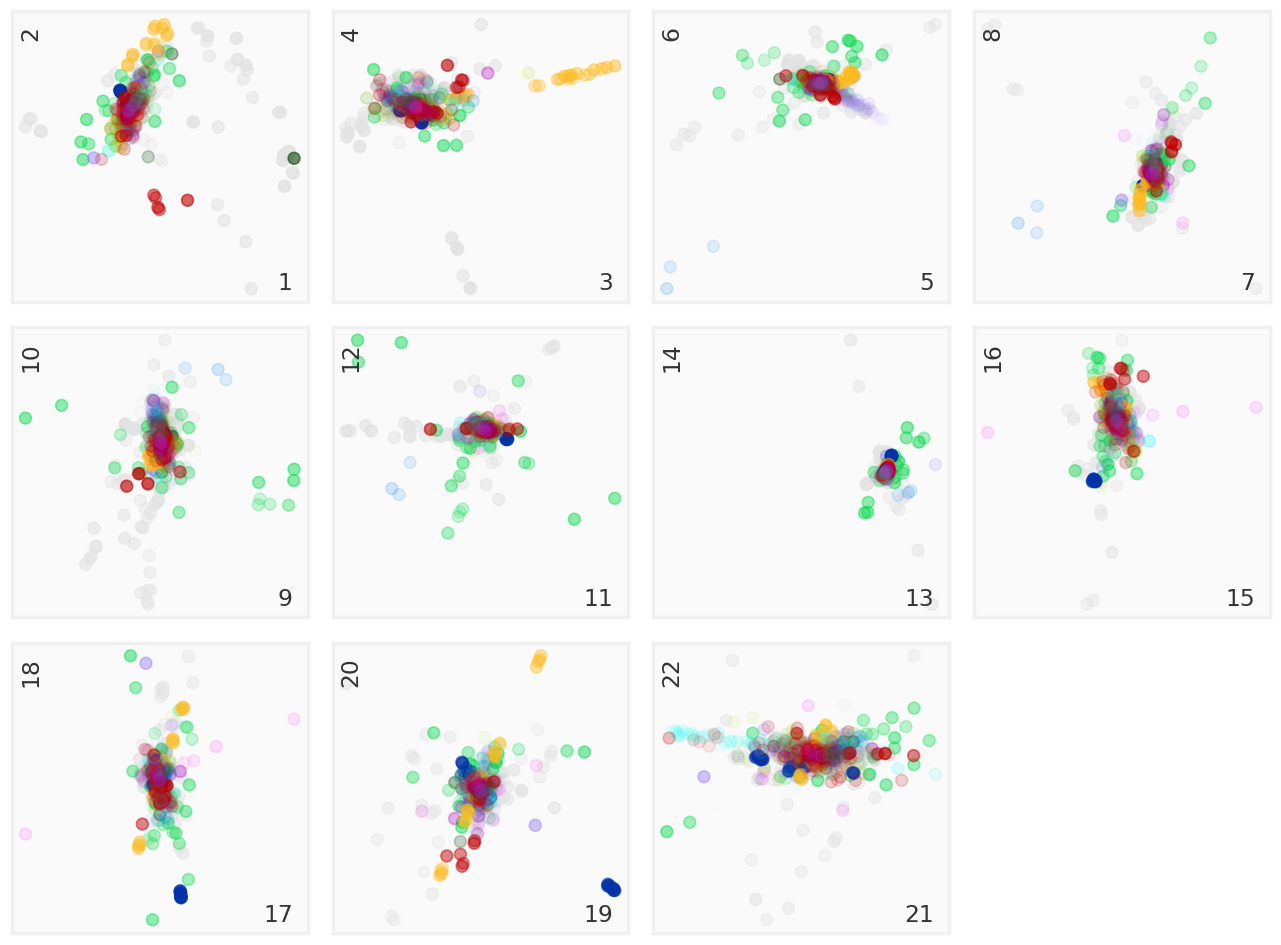

In [112]:
llm_method   = "ls-da3m0ns/bge_large_medical"
llm_ctype    = "kmeans"
labels       = get_llm_cluster_labels(np.array(trait_df.index), llm_method, llm_ctype)
label_colors = { label : hex_colors_40[i] for i, label in enumerate(np.unique(labels)) }
trait_h2     = trait_df['estimates.final.h2_observed'].fillna(1e-6).tolist()
alpha_factor = 2.0 if llm_ctype == "kmeans" else 2.0

axmain, axs = make_plot_principal_components(nnm_loadings, labels, label_colors, h2 = trait_h2, alpha_factor = alpha_factor)
plt.show()

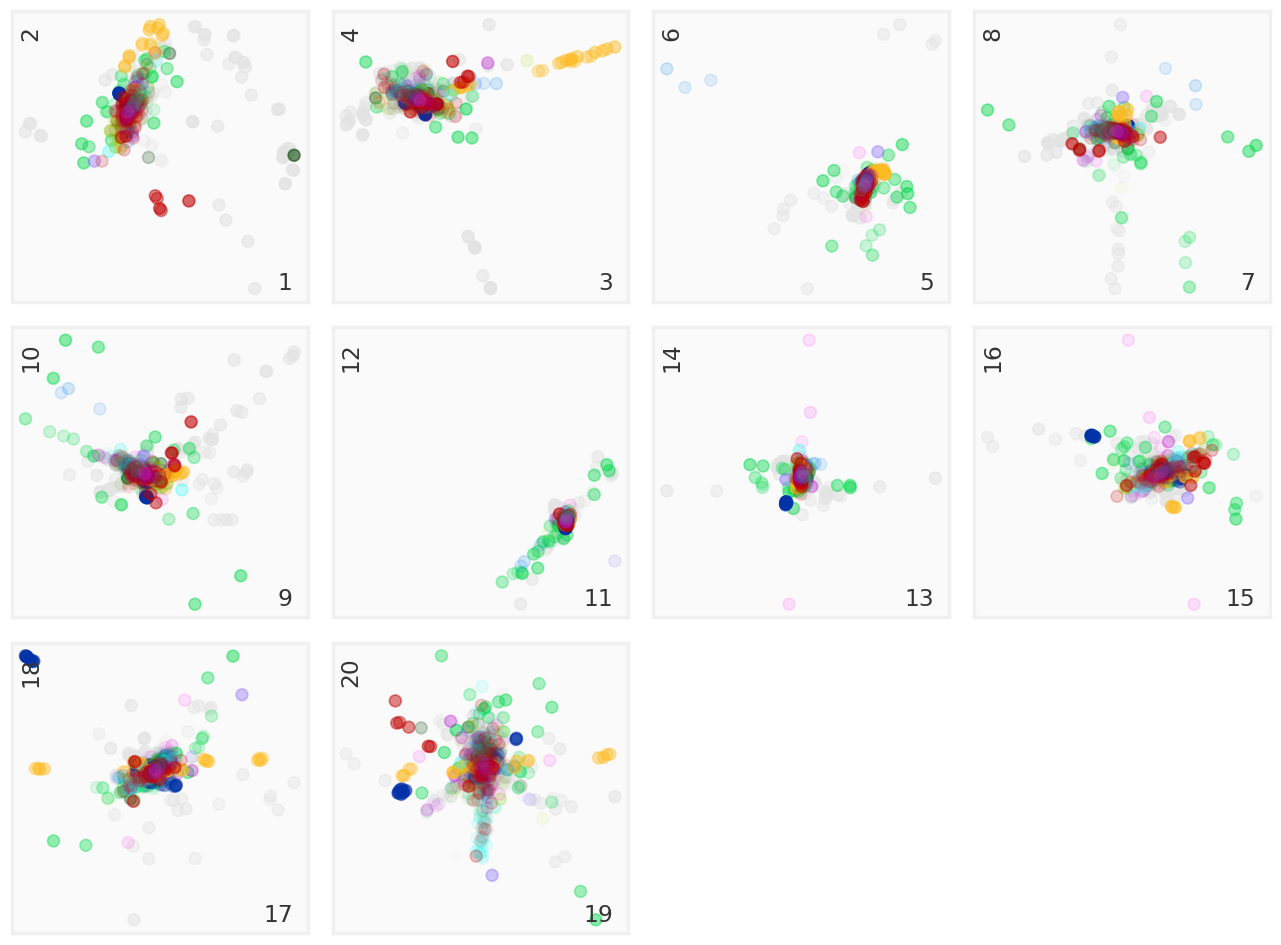

In [114]:
labels        = get_llm_cluster_labels(np.array(trait_df.index), llm_method, llm_ctype)
trait_df_noRx = trait_df.query('trait_type != "prescriptions"')
labels_noRx   = [labels[i] for i in trait_df_noRx.index]
trait_h2      = trait_df_noRx['estimates.final.h2_observed'].fillna(1e-6).tolist()

axmain, axs = make_plot_principal_components(nnm_loadings_noRx, labels_noRx, label_colors, h2 = trait_h2, alpha_factor = alpha_factor)
plt.show()

# Apply UMAP

We apply UMAP on four different data:

1. NNM loadings of all phenotypes
2. tSVD loadings of all phenotypes
3. NNM loadings of all phenotypes except prescriptions.
4. tSVD loadings of all phenotypes except prescriptions.

In [115]:
def get_umap_embedding(loadings, metric = 'cosine', n_neighbors = 15, min_dist = 0.4):
    reducer = umap.UMAP(n_neighbors = n_neighbors, metric = metric, min_dist = min_dist)
    return reducer.fit_transform(loadings)

umap_metrics = ['euclidean', 'cosine']
nnm_embedding       = { m : get_umap_embedding(nnm_loadings, metric = m) for m in umap_metrics }
tsvd_embedding      = { m : get_umap_embedding(tsvd_loadings, metric = m) for m in umap_metrics }
nnm_embedding_noRx  = { m : get_umap_embedding(nnm_loadings_noRx, metric = m) for m in umap_metrics }
tsvd_embedding_noRx = { m : get_umap_embedding(tsvd_loadings_noRx, metric = m) for m in umap_metrics }

# Interactive Plots

Each point is a PanUKB phenotype, colored according to the clusters identified by LLM models from the trait descriptions. The opaciy of each point is proportional to the estimated heritability of the trait.

In [116]:
def get_bokeh_plot(embedding, trait_labels, trait_df, plot_title, color_palette = hex_colors_40, alpha_factor = 10):
    
    plot_dict = dict(
        x = embedding[:, 0],
        y = embedding[:, 1],
        trait_type_code = [f"{x}" for x in trait_labels],
        h2_fill_alpha = [min(0.6, alpha_factor * x) for x in trait_df['estimates.final.h2_observed'].fillna(1e-6).tolist()],
        h2_line_alpha = [min(0.8, 1.3 * alpha_factor * x) for x in trait_df['estimates.final.h2_observed'].fillna(1e-6).tolist()],
        fulldesc = [f"{i} | {trait_df.loc[i, 'short_description']} | {trait_df.loc[i, 'estimates.final.h2_observed']:.3f} | {trait_df.loc[i, 'Neff']:.2f}" 
                    for i in trait_df.index],
    )

    color_mapping = CategoricalColorMapper(factors = [f"{x}" for x in np.unique(trait_labels)], palette = color_palette)

    plot_tooltips = [
        ("Desc", "@fulldesc"),
    ]

    ax = bokeh_figure(
        width = 800, height = 800, 
        tooltips = plot_tooltips,
        title = plot_title,
    )

    ax.circle('x', 'y', size = 10, 
        source = ColumnDataSource(plot_dict), 
        color = dict(field='trait_type_code', transform = color_mapping),
        line_alpha = dict(field='h2_line_alpha'),
        fill_alpha = dict(field='h2_fill_alpha'),
    )
    ax.title.text_font_size = '16pt'
    ax.title.text_font_style = 'normal'
    ax.title.text_font = 'tahoma'
    ax.axis.major_label_text_font_size = '20pt'
    ax.axis.axis_line_width = 2
    ax.axis.major_tick_line_width = 2
    ax.grid.visible = False
    return ax

In [122]:
#| label: fig-umap-embedding-nnm-loadings
#| fig-cap: "UMAP embeddings of the NNM loadings."

bokeh_colors = hex_colors_40.copy()
bokeh_colors[0] = "#3c3c3c0d"
llm_method   = "ls-da3m0ns/bge_large_medical"
llm_ctype    = "community"
alpha_factor = 10 if llm_ctype == "kmeans" else 100
labels       = get_llm_cluster_labels(np.array(trait_df.index), llm_method, llm_ctype)

axlist = list()
for metric in umap_metrics:
    ax = get_bokeh_plot(
        nnm_embedding[metric], labels, trait_df, 
        f"NNM, {metric}, {llm_method}, {llm_ctype} clustering",
        alpha_factor = alpha_factor,
        color_palette = bokeh_colors
    )
    axlist.append(ax)
    
# put all the plots in a VBox
p = bokeh_column(*axlist)

# show the results
bokeh_show(p)

In [123]:
#| label: fig-umap-embedding-tsvd-loadings
#| fig-cap: "UMAP embeddings of the tSVD embeddings."

axlist = list()
for metric in umap_metrics:
    ax = get_bokeh_plot(
        tsvd_embedding[metric], labels, trait_df, 
        f"tSVD, {metric}, {llm_method}, {llm_ctype} clustering",
        alpha_factor = alpha_factor,
        color_palette = bokeh_colors
    )
    axlist.append(ax)
    
# put all the plots in a VBox
p = bokeh_column(*axlist)

# show the results
bokeh_show(p)

In [124]:
#| label: fig-umap-embedding-nnm-loadings-noRx
#| fig-cap: "UMAP embeddings of the NNM loadings except prescriptions."

labels        = get_llm_cluster_labels(np.array(trait_df.index), llm_method, llm_ctype)
trait_df_noRx = trait_df.query('trait_type != "prescriptions"')
labels_noRx   = [labels[i] for i in trait_df_noRx.index]

axlist = list()
for metric in umap_metrics:
    ax = get_bokeh_plot(
        nnm_embedding_noRx[metric], labels_noRx, trait_df_noRx, 
        f"NNM, {metric}, {llm_method}, {llm_ctype} clustering",
        alpha_factor = alpha_factor,
        color_palette = bokeh_colors
    )
    axlist.append(ax)
    
# put all the plots in a VBox
p = bokeh_column(*axlist)

# show the results
bokeh_show(p)

In [125]:
#| label: fig-umap-embedding-tsvd-loadings-noRx
#| fig-cap: "UMAP embeddings of the tSVD loadings except prescriptions."

axlist = list()
for metric in umap_metrics:
    ax = get_bokeh_plot(
        tsvd_embedding_noRx[metric], labels_noRx, trait_df_noRx, 
        f"tSVD, {metric}, {llm_method}, {llm_ctype} clustering",
        alpha_factor = alpha_factor,
        color_palette = bokeh_colors
    )
    axlist.append(ax)
    
# put all the plots in a VBox
p = bokeh_column(*axlist)

# show the results
bokeh_show(p)